# Summary

Game scores are useful for identifying which team is likely to win a given game against another team. Point scores are useful for saying which team is likely to win a given point against another team.

The problems with this approach were the same problems with my original effort based on simple wins and losses. I resolved those problems with help from PyMC3 developers, and now my original model works well. I am holding off on further development of this approach using point scores for now.

In [1]:
import pandas as pd
import os
import numpy as np
import pymc3 as pm
from pymc3.math import invlogit
from tqdm import tqdm
from theano import tensor as tt

%matplotlib inline

In [2]:
project_dir = '/Users/rbussman/Projects/BUDA/buda-ratings'
scores_dir = os.path.join(project_dir, 'data', 'raw', 'game_scores')

In [3]:
# summer club league 2016
league_id = 40264
game_scores = pd.read_csv(os.path.join(scores_dir, 'scores_{}.csv'.format(league_id)))

In [4]:
game_scores.head()

,Team A,Team B,Tourney Qualifying games*,divname,Score A,Score B
0,AHOC,Gothrilla,-99,4/3 Div 1,15,12
1,AHOC,BBN,-99,4/3 Div 1,15,1
2,AHOC,Stonecutters,-99,4/3 Div 1,15,8
3,AHOC,FlowChart,-99,4/3 Div 1,15,10
4,AHOC,Lady and the BAMF,-99,4/3 Div 1,15,5


In [5]:
game_scores['Team A'].unique()

array(['AHOC', 'Gothrilla', 'FlowChart', 'GrassBurner', 'Zerg Rush!',
       'Swingers', 'TuneSquad', 'Turtle Boy',
       'Live Poultry, Fresh Killed (LPFK)', 'BBN', 'Upstream',
       'Injustice League', 'Puddingstone', 'Flaming Croissants',
       "Jack's Abby HAOS Lager",
       'License to Kilt (fka Scoobers in Scotland)', 'Toads', 'JHOP',
       'Rubs The Duckie', 'Disc Envy', 'Store Bought Dirt', 'Fetch',
       'Booooooosh!', 'Dominion', "Rogues' Gallery", 'A Lil Bit Sticky',
       'Nerd Alert', 'Moose Lightning', 'Lady and the BAMF', 'Tubbs',
       'Hipster Kitties', 'TuneSquad Squared', 'Too Drunk to Fail',
       'Oddjob', 'Batman and the Robins', 'Stack to the Future',
       'Underwater Monkey Cowboys', 'Baboon Heart', 'Top Shelf',
       '123 Trap!', 'SnakeCountryBromance', 'Stonecutters',
       'Shake and Bake', 'JuJu Hex', 'Pink Flamingos', 'Baba Yaga',
       'Maverick', 'Hippos', 'Bacon', 'Get Flat Ultimate',
       'Hucky McThrowandcatch', 'SHRedline', 'The Funky 

In [6]:
game_scores['divname'].unique()

array(['4/3 Div 1', '4/3 Div 2', '4/3 Div 3', '5/2 Div 1', '5/2 Div 2',
       '5/2 Div 3', 'Open Div 1', 'Open Div 2'], dtype=object)

In [7]:
teams = game_scores['Team A'].unique()

In [8]:
div1_index = 0
div2_index = 0
div3_index = 0
open1_index = 0
open2_index = 0
team2index = {}
team2div = {}
for i, team in enumerate(teams):
    row = game_scores['Team A'] == team
    div_team = game_scores.loc[row, 'divname'].unique()[0]
    team2div[team] = div_team
    
    if div_team == '4/3 Div 1' or div_team == '5/2 Div 1':
        team2index[team] = div1_index
        div1_index += 1
        
    if div_team == '4/3 Div 2' or div_team == '5/2 Div 2':
        team2index[team] = div2_index
        div2_index += 1   
        
    if div_team == '4/3 Div 3' or div_team == '5/2 Div 3':
        team2index[team] = div3_index
        div3_index += 1
        
    if div_team == 'Open Div 1':
        team2index[team] = open1_index
        open1_index += 1
        
    if div_team == 'Open Div 2':
        team2index[team] = open2_index
        open2_index += 1
        

In [9]:
game_points = []
for row in game_scores.index:
    
    team_A = game_scores.loc[row, 'Team A']
    team_B = game_scores.loc[row, 'Team B']
    div_A = team2div[team_A]
    div_B = team2div[team_B]
    index_A = team2index[team_A]
    index_B = team2index[team_B]
    
    scores_A = game_scores.loc[row, 'Score A']
    scores_B = game_scores.loc[row, 'Score B']
    for i in range(scores_A):
        game_point = {
            'Team A': team_A,
            'Team B': team_B,
            'Team A Scores': True,
            'Div A': div_A,
            'Div B': div_B,
            'Index A': index_A,
            'Index B': index_B
        }
        game_points.append(game_point)
        
    for i in range(scores_B):
        game_point = {
            'Team A': team_A,
            'Team B': team_B,
            'Team A Scores': False,
            'Div A': div_A,
            'Div B': div_B,
            'Index A': index_A,
            'Index B': index_B
        }
        game_points.append(game_point)
        
game_points = pd.DataFrame(game_points)

In [10]:
game_points.head()

,Div A,Div B,Index A,Index B,Team A,Team A Scores,Team B
0,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
1,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
2,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
3,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
4,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla


In [11]:
n_teams = len(teams)

In [12]:
n_teams

78

In [13]:
pair_list = []
for row in tqdm(game_points.index):
    team_A = game_points.loc[row, 'Team A']
    team_B = game_points.loc[row, 'Team B']
    new_pair = (team_A, team_B)
    pair_list.append(new_pair)
    reverse_pair = (team_B, team_A)
    if reverse_pair in pair_list:
        game_points = game_points.drop(row)


100%|██████████| 27362/27362 [01:02<00:00, 435.54it/s]


In [14]:
len(game_points)

13681

In [15]:
game_points = game_points.reset_index().drop('index', axis=1)

In [16]:
game_points.tail(15)

,Div A,Div B,Index A,Index B,Team A,Team A Scores,Team B
13666,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13667,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13668,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13669,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13670,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13671,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13672,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13673,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13674,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone
13675,Open Div 2,Open Div 2,0,1,I'm not gonna not play Flong,True,Sky Zone


In [17]:
d1_index = (game_points['Div A'] == '4/3 Div 1') & (game_points['Div B'] == '4/3 Div 1')
# true_index = (mixed_scores['Index B'] < 30) & (mixed_scores['ID A'] < 30)
d1_points = game_points[d1_index]

In [18]:
d1_points.shape

(1162, 7)

In [19]:
nteams = len(set(np.append(d1_points['Team A'].unique(), d1_points['Team B'].unique())))

In [20]:
nteams

10

In [21]:
d1_points.head(30)

,Div A,Div B,Index A,Index B,Team A,Team A Scores,Team B
0,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
1,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
2,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
3,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
4,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
5,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
6,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
7,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
8,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla
9,4/3 Div 1,4/3 Div 1,0,1,AHOC,True,Gothrilla


In [22]:
d1_points.shape

(1162, 7)

In [36]:
skill_prior_div = {
    '4/3 Div 1': 0.62,
    '4/3 Div 2': 0.0,
    '4/3 Div 3': -0.28,
    '5/2 Div 1': 0.62,
    '5/2 Div 2': -0.05,
    '5/2 Div 3': -0.35,
    'Open Div 1': 0.0,
    'Open Div 2': -0.28
}
alphas = []
for team in teams:
    div = team2div[team]
    alpha = skill_prior_div[div]
    alphas.append(alpha)

In [37]:
len(alphas)

78

In [39]:
with pm.Model() as model:
    skill = pm.Cauchy('skill', alpha=alphas, beta=0.5, shape=n_teams)

    B_minus_A = skill[game_points['Index B'].values] - skill[game_points['Index A'].values]

    lower = 1e-6
    upper = 1 - 1e-6
    probability_A_beats_B = lower + (upper - lower) * 1 / (1 + tt.exp(B_minus_A))
    
#     probability_A_beats_B = pm.math.invlogit(A_minus_B)
#     probability_A_beats_B = 1. / (1 + pm.math.exp(B_minus_A))
    
    observation = pm.Bernoulli('observation', probability_A_beats_B, observed=game_points['Team A Scores'].values)
    
    

In [40]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 9,378.9:   7%|▋         | 14643/200000 [00:26<05:15, 587.42it/s]
Convergence archived at 14700
Interrupted at 14,700 [7%]: Average Loss = 9,669.2
100%|██████████| 1500/1500 [09:20<00:00,  6.54it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113db0a50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113760a50>]], dtype=object)

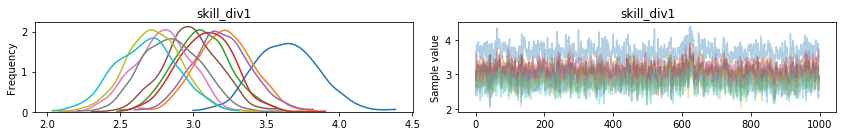

In [27]:
pm.traceplot(trace)

In [41]:
trace.varnames

['skill']

In [42]:
meanskills = trace.get_values('skill').mean(axis=0)

In [31]:
teamlist = np.unique(np.append(d1_points['Team A'].unique(), d1_points['Team B'].unique()))

In [44]:
meanskills

array([ 0.65301083,  0.44547386,  0.42931924,  0.33030892,  0.37333916,
        0.24718034,  0.16499764,  0.12679952,  0.22163357,  0.24839653,
        0.27370629,  0.32321066,  0.08341891,  0.09051705,  0.05448306,
       -0.07004865, -0.13926281, -0.08893653, -0.07052182, -0.29699215,
       -0.40601642, -0.46361128,  0.6869104 ,  0.67144911,  0.56612181,
        0.58125229,  0.358072  ,  0.36400688,  0.21634662,  0.27169866,
        0.22357252,  0.06636634,  0.03481271, -0.34979988, -0.46372342,
       -0.10313796,  0.01004278,  0.03618744,  0.1109608 , -0.24434164,
        0.57749495,  0.8656889 ,  1.37702863,  2.16685353,  0.09309964,
        0.04399854, -0.43583996,  0.01278415,  0.15011313,  0.10308817,
       -0.07928212, -1.11573001,  0.10926464, -0.09345529, -0.70139447,
       -0.06994451, -0.30991279, -0.72070356, -0.26859341, -0.54762425,
       -0.28048939, -0.28969197, -0.27292897, -0.58404238, -6.59882065,
        0.10637341, -0.84579763,  0.64191211, -0.30014218,  0.07

In [45]:
alphas

[0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.62,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.28,
 -0.28,
 -0.28,
 -0.28,
 -0.28,
 -0.28,
 -0.28,
 -0.28,
 0.62,
 0.62,
 0.62,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.05,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 -0.35,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.28,
 -0.28]

In [43]:
for i, meanskill in enumerate(meanskills):
    if i == 0 or i == 13:
        index = game_points['Index A'] == i
        name = game_points.loc[index, 'Team A'].unique()[0]
    else:
        index = game_points['Index B'] == i
        name = game_points.loc[index, 'Team B'].unique()[0]
    print("{}: {:.3f}".format(name, meanskill))

AHOC: 0.653
Gothrilla: 0.445
FlowChart: 0.429
GrassBurner: 0.330
Zerg Rush!: 0.373
Swingers: 0.247
TuneSquad: 0.165
Turtle Boy: 0.127
Live Poultry, Fresh Killed (LPFK): 0.222
BBN: 0.248
SnakeCountryBromance: 0.274
Stonecutters: 0.323
Shake and Bake: 0.083
Dominion: 0.091
Rogues' Gallery: 0.054
A Lil Bit Sticky: -0.070
Nerd Alert: -0.139
Moose Lightning: -0.089
Lady and the BAMF: -0.071
Tubbs: -0.297
Hipster Kitties: -0.406
TuneSquad Squared: -0.464
JuJu Hex: 0.687
Pink Flamingos: 0.671
Baba Yaga: 0.566
Maverick: 0.581
Hippos: 0.358
Bacon: 0.364
Get Flat Ultimate: 0.216
Hucky McThrowandcatch: 0.272
SHRedline: 0.224
The Funky Bunch: 0.066
Iron Squids: 0.035


IndexError: index 0 is out of bounds for axis 0 with size 0

In [52]:
i

13